# Titanic dataset

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [2]:
train_data, test_data = load_titanic_data()

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

- Passengerid: a unique identifier for each passenger
- Survived: that's the target, 0 means the passender did not survive, while 1 means they survived
- Pclass: passenger class
- Name, sex, age: obvious
- SibSp: how many siblings & spouses of the passenger aboard the Titanic
- Parch: how many children & parents of the passender aboar the Titanic
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: cabin number
- Embarked: where the passenger embarked the Titanic

In [4]:
# explicitly set the Passengerid column as the index column
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Only 38% survived! Accuracy should be a reasonable metric to evaluate the model.

In [7]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Look at categorical attributes

In [8]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [9]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [10]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Build preprocessing pipline

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [12]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False))
])

In [13]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])


In [14]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]], shape=(891, 12))

In [15]:
y_train = train_data["Survived"]

Try a random forest classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [18]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

np.float64(0.8137578027465668)

Now try SVC

In [19]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

np.float64(0.8249313358302123)

Plot the mean accuracy across the 10 cross-validation folds.

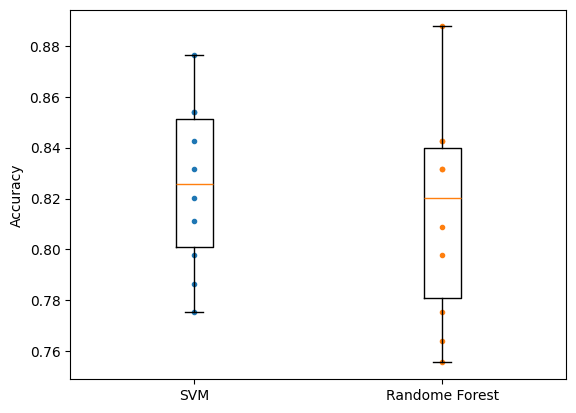

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=("SVM", "Randome Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier had a high score on one of the ten folds, but a lower mean score and wider spread of accuracy. SVM looks like it would generalize to test data better than random forest classifier.

In [26]:
# Practice some feature engineering

train_data["age_bucket"] = train_data["Age"] // 10 * 10
train_data[["age_bucket", "Survived"]].groupby(["age_bucket"]).mean()


,Survived
age_bucket,
0.0,0.612903
10.0,0.401961
20.0,0.350000
30.0,0.437126
40.0,0.382022
50.0,0.416667
60.0,0.315789
70.0,0.000000
80.0,1.000000


# Spam classifier

- Download examples of spam and ham from Apache SpamAssassin's public datasets.
- Unzip the datasets and get familiar with datasets.
- Split datasets into a training set and a test set. 
- Write a data prep pipeline to convert each email into a feature vector. The pipeline should transform an email into a (sparse) word vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello" "how" "are" "you" then the email "Hello you Hello Hello you" would be converted to [1, 0, 0, 1] or [3, 0, 0, 2].

In [31]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets_spam" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading...", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [32]:
ham_dir, spam_dir = fetch_spam_data()

Downloading... datasets_spam\spam\spam.tar.bz2


C:\Users\Paul.Carvalho\AppData\Local\Temp\ipykernel_21252\1589686.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


Load all of the files

In [ ]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [37]:
len(ham_filenames)

2500

In [38]:
len(spam_filenames)

500

Use Python's ```email``` module to parse emails (headers, encoding, etc.)

In [41]:
import email
import email.parser
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [42]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Take a look at an example of ham and spam to get a feel for what the data looks like.

In [43]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [44]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40
